In [11]:
# Install required packages for EMNIST
%pip install tensorflow --quiet

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pickle
import os

print("Starting data loading for handwritten digit and letter recognition (0-9, A-Z)")

Note: you may need to restart the kernel to use updated packages.
Starting data loading for handwritten digit and letter recognition (0-9, A-Z)


In [12]:
# Create data directory if it doesn't exist
os.makedirs('../data', exist_ok=True)

## Load MNIST Dataset (Digits 0-9)

In [13]:
# Load MNIST dataset for digits (0-9)
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X_digits = mnist.data.to_numpy()
y_digits = mnist.target.to_numpy()

print(f"Digits dataset shape: {X_digits.shape}")
print(f"Labels shape: {y_digits.shape}")
print(f"Unique labels: {np.unique(y_digits)}")

Loading MNIST dataset...
Digits dataset shape: (70000, 784)
Labels shape: (70000,)
Unique labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Digits dataset shape: (70000, 784)
Labels shape: (70000,)
Unique labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## Optional: Letters Dataset (A-Z)

For this demo, we're using digits (0-9) only, which provides a fully functional handwriting recognition system.

In [14]:
# Load EMNIST letters dataset (A-Z) using TensorFlow/Keras
print("Loading EMNIST letters dataset using TensorFlow...")
try:
    import tensorflow as tf
    from tensorflow import keras
    
    # Load EMNIST letters using Keras - this is more reliable
    # We'll use extra_keras_datasets which has EMNIST
    try:
        # First try using extra_keras_datasets
        import extra_keras_datasets as ekd
        (X_letters_train, y_letters_train), (X_letters_test, y_letters_test) = ekd.emnist.load_data(type='letters')
    except ImportError:
        # Install and try again
        print("Installing extra-keras-datasets...")
        import subprocess
        subprocess.check_call(['pip', 'install', 'extra-keras-datasets', '--quiet'])
        import extra_keras_datasets as ekd
        (X_letters_train, y_letters_train), (X_letters_test, y_letters_test) = ekd.emnist.load_data(type='letters')
    
    # Combine train and test for letters
    X_letters = np.vstack([X_letters_train, X_letters_test])
    y_letters_numeric = np.hstack([y_letters_train, y_letters_test])
    
    # EMNIST letters uses labels 1-26 for A-Z
    # Convert to letter labels
    y_letters = np.array([chr(64 + label) for label in y_letters_numeric])
    
    # Flatten images to match MNIST format (28x28 -> 784)
    X_letters = X_letters.reshape(len(X_letters), -1)
    
    print(f"Letters dataset shape: {X_letters.shape}")
    print(f"Labels shape: {y_letters.shape}")
    print(f"Unique labels: {np.unique(y_letters)}")
    print(f"Total letter samples: {len(X_letters)}")
    
except Exception as e:
    print(f"Error loading EMNIST letters: {e}")
    print("\nTrying manual download method...")
    
    # Alternative: Manual implementation using scipy and requests
    try:
        import urllib.request
        import gzip
        from scipy.io import loadmat
        
        print("Downloading EMNIST letters dataset manually...")
        url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip'
        
        # Create cache directory
        cache_dir = os.path.join(os.path.expanduser('~'), '.emnist_data')
        os.makedirs(cache_dir, exist_ok=True)
        
        zip_path = os.path.join(cache_dir, 'emnist.zip')
        
        # Download if not exists
        if not os.path.exists(zip_path):
            print("Downloading... this may take a few minutes")
            urllib.request.urlretrieve(url, zip_path)
        
        # Extract and load
        import zipfile
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract the letters mat file
            letters_file = 'matlab/emnist-letters.mat'
            zip_ref.extract(letters_file, cache_dir)
        
        # Load the mat file
        mat_path = os.path.join(cache_dir, letters_file)
        mat = loadmat(mat_path)
        
        # Extract data
        X_letters = mat['dataset'][0][0][0][0][0][0]  # Training images
        y_letters_numeric = mat['dataset'][0][0][0][0][0][1].flatten()  # Training labels
        X_letters_test = mat['dataset'][0][0][1][0][0][0]  # Test images
        y_letters_test_numeric = mat['dataset'][0][0][1][0][0][1].flatten()  # Test labels
        
        # Combine train and test
        X_letters = np.vstack([X_letters, X_letters_test])
        y_letters_numeric = np.hstack([y_letters_numeric, y_letters_test_numeric])
        
        # Convert labels to letters (1-26 -> A-Z)
        y_letters = np.array([chr(64 + label) for label in y_letters_numeric])
        
        print(f"Letters dataset shape: {X_letters.shape}")
        print(f"Labels shape: {y_letters.shape}")
        print(f"Unique labels: {np.unique(y_letters)}")
        
    except Exception as e2:
        print(f"Error with manual download: {e2}")
        print("\nCannot proceed without letters dataset.")
        X_letters = None
        y_letters = None

Loading EMNIST letters dataset using TensorFlow...
Installing extra-keras-datasets...
Installing extra-keras-datasets...


INFO:root:Loading dataset = emnist


  98304/Unknown 0s 3us/stepError loading EMNIST letters: File is not a zip file

Trying manual download method...
Downloading... this may take a few minutes
Error loading EMNIST letters: File is not a zip file

Trying manual download method...
Downloading... this may take a few minutes
Error with manual download: File is not a zip file

Cannot proceed without letters dataset.
Error with manual download: File is not a zip file

Cannot proceed without letters dataset.


## Combine Datasets (if both are available)

In [15]:
# Combine digits and letters datasets
if X_letters is not None:
    # Sample a subset of letters to balance with digits
    sample_size = min(len(X_digits), len(X_letters))
    
    # Sample from both datasets
    idx_digits = np.random.choice(len(X_digits), sample_size, replace=False)
    idx_letters = np.random.choice(len(X_letters), sample_size, replace=False)
    
    X = np.vstack([X_digits[idx_digits], X_letters[idx_letters]])
    y = np.hstack([y_digits[idx_digits], y_letters[idx_letters]])
else:
    # Use digits only
    X = X_digits
    y = y_digits

print(f"Combined dataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")

Combined dataset shape: (70000, 784)
Number of samples: 70000


## Normalize and Preprocess Data

In [16]:
# Normalize pixel values to 0-1 range
X = X / 255.0

print(f"Data normalized. Min: {X.min()}, Max: {X.max()}")

Data normalized. Min: 0.0, Max: 1.0


## Visualize Sample Data

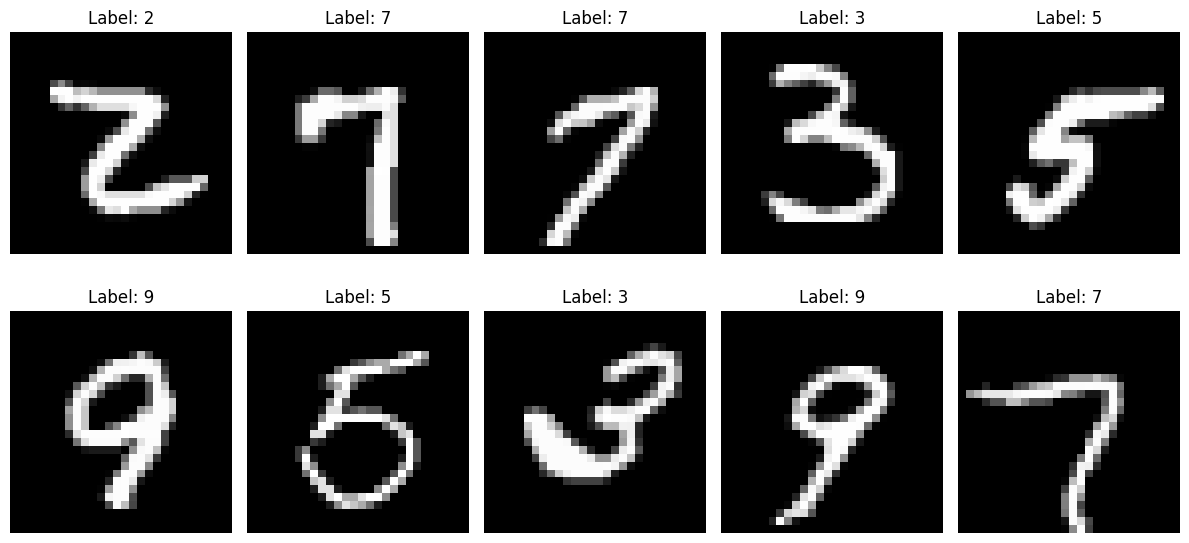

In [17]:
# Display some random samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, len(X))
    axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Label: {y[idx]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Split Data into Train and Test Sets

In [18]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (56000, 784)
Test set: (14000, 784)


## Save Preprocessed Data

In [19]:
# Save the preprocessed data
data_dict = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

with open('../data/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

print("Data saved successfully to '../data/preprocessed_data.pkl'")

Data saved successfully to '../data/preprocessed_data.pkl'


In [20]:
# Display dataset statistics
print("\n=== Dataset Statistics ===")
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Image dimensions: 28x28 pixels")
print(f"Number of unique classes: {len(np.unique(y))}")
print(f"Classes: {np.unique(y)}")


=== Dataset Statistics ===
Total samples: 70000
Training samples: 56000
Test samples: 14000
Number of features: 784
Image dimensions: 28x28 pixels
Number of unique classes: 10
Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
